# BSM Pricing Model

The Black-Scholes equation requires five variables. These inputs are volatility, the price of the underlying asset, the strike price of the option, the time until expiration of the option, and the risk-free interest rate.

Call option price $= N(d1)St- N(d2)Ke^{-r(T - t)}$

Put option price $= N(-d2)Ke^{-r(T - t)} - N(-d1)St$

$d1 = \frac{\ln(\frac{St}{K}) + (r + \frac{\sigma^2}{2})(T - t)}{\sigma\sqrt{(T - t)}}$

$d2 = d1 - \sigma\sqrt{(T - t)}$

- S<sub>t</sub> = current stock price
- K = strike price
- r = risk-free interest rate
- t = time to maturity
- N = normal distribution

In [65]:
# Python imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

In [66]:
# Black Scholes Model price calculation
def get_bsm_price(St, K, r, t, v, q=0, option="both"):
    """Return Black-Scholes-Merton option prices.
    option: 'call', 'put', or 'both'"""
    # handle edge cases: zero time or zero volatility -> intrinsic values
    if t <= 0 or v == 0:
        call = max(0.0, St - K)
        put = max(0.0, K - St)
    else:
        sqrt_t = np.sqrt(t)
        d1 = (np.log(St / K) + (r + 0.5 * v**2) * t) / (v * sqrt_t)
        d2 = d1 - v * sqrt_t

        call = norm.cdf(d1) * (St * np.exp(-q * t)) - norm.cdf(d2) * K * np.exp(-r * t)
        put = norm.cdf(-d2) * K * np.exp(-r * t) - norm.cdf(-d1) * (St * np.exp(-q * t))

    if option == 'call':
        return call
    elif option == 'put':
        return put
    else:
        return {"call": call, "put": put}

In [67]:
# Ploting functions
def plot_sns_heatmap(data, title, xtick, ytick, colormap, ax=None):
    # If no axis is provided, create a new figure (smaller size to avoid scrolling)
    if ax is None:
        plt.figure(figsize=(6, 5))
        ax = plt.gca()

    sns.heatmap(
        data,
        annot=True,
        fmt=".2f",
        xticklabels=np.round(xtick, 2),
        yticklabels=np.round(ytick, 2),
        cmap=colormap,
        # center=np.mean(data),
        linewidths=0.5,
        linecolor='white',
        ax=ax
    )
    ax.set_xlabel("Spot price")
    ax.set_ylabel("Volatility")
    ax.set_title(title)

def compute_and_plot(spot_min, spot_max, vol_min, vol_max, K, r, t, q, purchase_price=0):
    
    if spot_min > spot_max:
        spot_min, spot_max = spot_max, spot_min
    if vol_min > vol_max:
        vol_min, vol_max = vol_max, vol_min

    spot_prices = np.linspace(spot_min, spot_max, 11)
    volatilities = np.linspace(vol_min, vol_max, 11)

    call_result = np.zeros((len(volatilities), len(spot_prices)))
    put_result = np.zeros((len(volatilities), len(spot_prices)))

    for i, volatility in enumerate(volatilities):
        for j, spot_price in enumerate(spot_prices):
            result = get_bsm_price(spot_price, K, r, t, volatility, q)
            call_result[i, j] = result['call']
            put_result[i, j] = result['put']

    # Create a figure with 2 subplots side-by-side
    # Increased figsize for bigger heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    colormap='viridis'

    if purchase_price:
        call_result -= purchase_price
        put_result -= purchase_price
        colormap = 'RdYlGn'
    
    plot_sns_heatmap(call_result, "Call", spot_prices, volatilities, colormap, ax=axes[0])
    plot_sns_heatmap(put_result, "Put", spot_prices, volatilities, colormap, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

## Option Pricing Heatmap

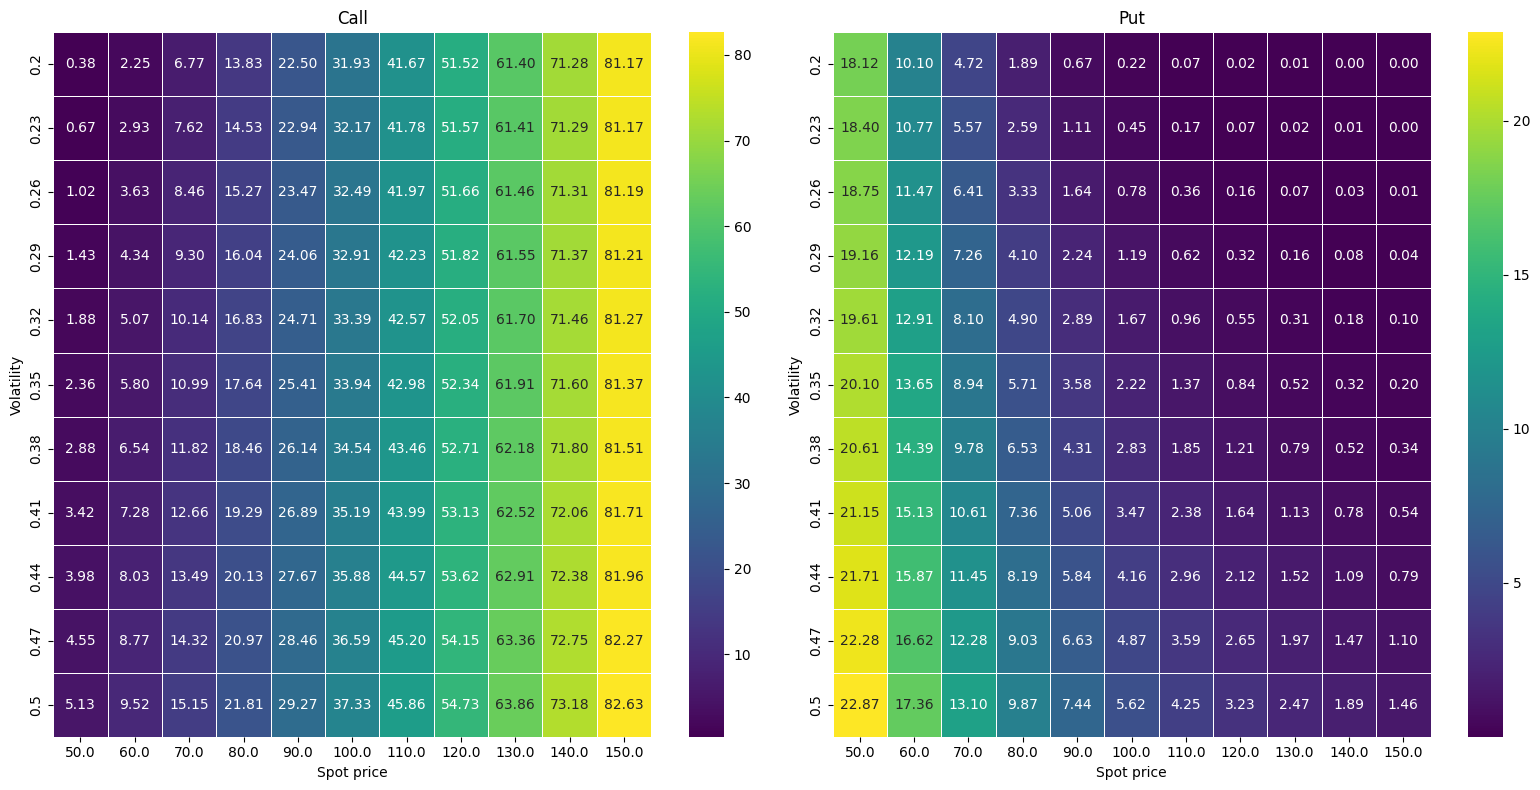

In [68]:

K_widget = widgets.FloatText(
    value=75, 
    description='Strike price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
r_widget = widgets.FloatText(
    value=0.1, 
    description='Risk-free Rate:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
t_widget = widgets.FloatText(
    value=1.1, 
    description='Time to Maturity:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
q_widget = widgets.FloatText(
    value=0.01, 
    description='Dividend Yield:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)

vol_range_slider = widgets.FloatRangeSlider(
    value=[0.2, 0.5],
    min=0.01,
    max=1.0,
    step=0.01,
    description='Volatility Range:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
spot_min_widget = widgets.FloatText(
    value=50, 
    description='Min Spot Price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
spot_max_widget = widgets.FloatText(
    value=150, 
    description='Max Spot Price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)

# Layout: organize widgets in rows with space-between for alignment
input_row_1 = widgets.HBox(
    [K_widget, r_widget, t_widget, q_widget],
    layout=widgets.Layout(width='100%', justify_content='space-between')
)
input_row_2 = widgets.HBox(
    [vol_range_slider, spot_min_widget, spot_max_widget],
    layout=widgets.Layout(width='100%', justify_content='flex-end')
)

def update_plot(change=None):
    """Update the plot when any widget value changes"""
    clear_output(wait=True)
    vol_min, vol_max = vol_range_slider.value
    compute_and_plot(
        spot_min_widget.value,
        spot_max_widget.value,
        vol_min,
        vol_max,
        K_widget.value,
        r_widget.value,
        t_widget.value,
        q_widget.value,
    )
    # Re-display the widgets after the plot
    display(ui)

# Attach the update function to all widgets
K_widget.observe(update_plot, 'value')
r_widget.observe(update_plot, 'value')
t_widget.observe(update_plot, 'value')
q_widget.observe(update_plot, 'value')
vol_range_slider.observe(update_plot, 'value')
spot_min_widget.observe(update_plot, 'value')
spot_max_widget.observe(update_plot, 'value')

# Display the UI
ui = widgets.VBox([input_row_1, input_row_2])
display(ui)

# Initial plot
update_plot()

## P&L Heatmap

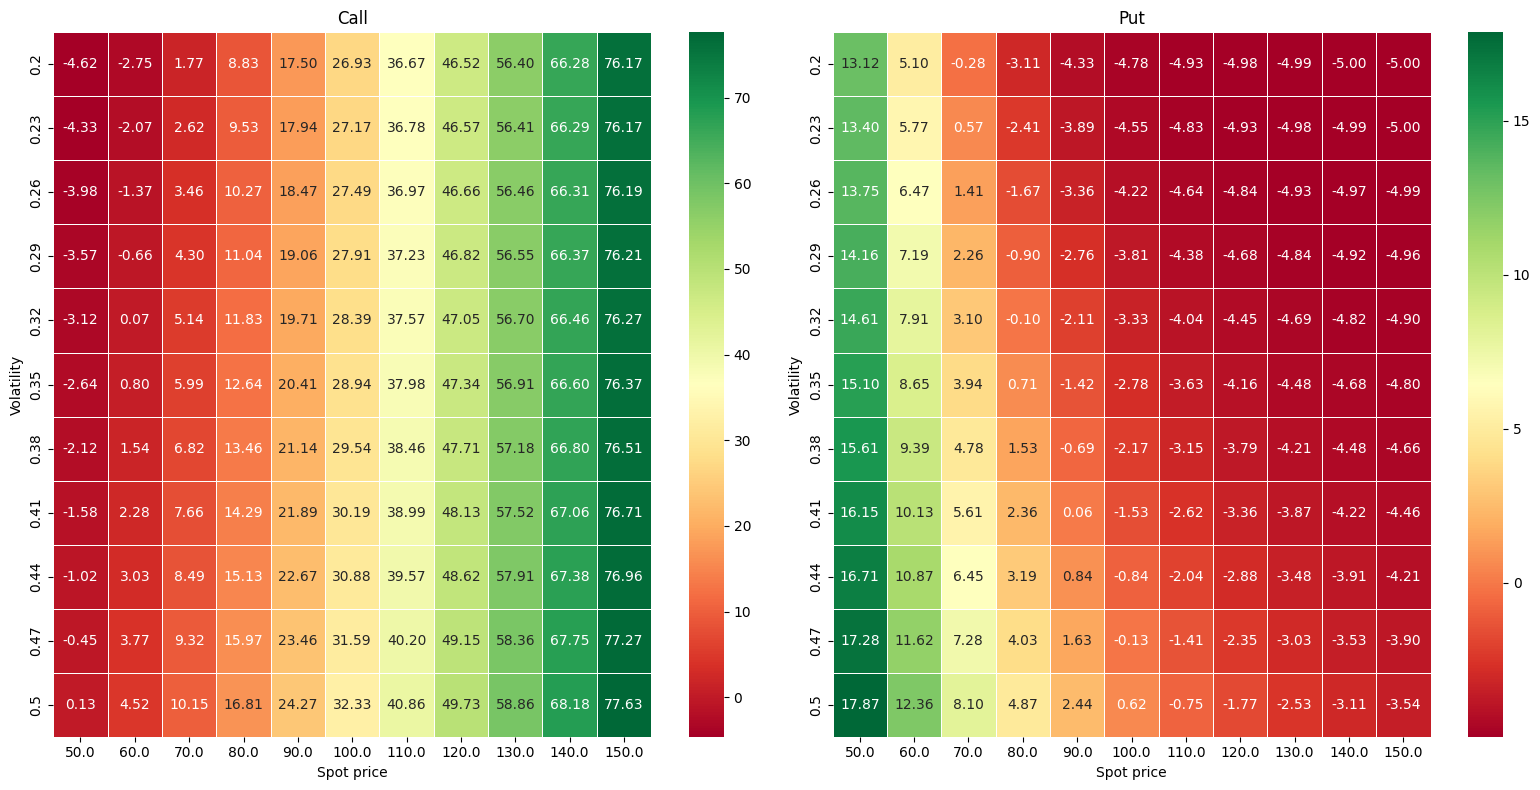

In [69]:

K_widget = widgets.FloatText(
    value=75, 
    description='Strike price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
r_widget = widgets.FloatText(
    value=0.1, 
    description='Risk-free Rate:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
t_widget = widgets.FloatText(
    value=1.1, 
    description='Time to Maturity:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
q_widget = widgets.FloatText(
    value=0.01, 
    description='Dividend Yield:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)

pprice_widget = widgets.FloatText(
    value=5, 
    description='Purchase Price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
vol_range_slider = widgets.FloatRangeSlider(
    value=[0.2, 0.5],
    min=0.01,
    max=1.0,
    step=0.01,
    description='Volatility Range:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
spot_min_widget = widgets.FloatText(
    value=50, 
    description='Min Spot Price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)
spot_max_widget = widgets.FloatText(
    value=150, 
    description='Max Spot Price:', 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='24%')
)

# Layout: organize widgets in rows with space-between for alignment
input_row_1 = widgets.HBox(
    [K_widget, r_widget, t_widget, q_widget],
    layout=widgets.Layout(width='100%', justify_content='space-between')
)
input_row_2 = widgets.HBox(
    [pprice_widget, vol_range_slider, spot_min_widget, spot_max_widget],
    layout=widgets.Layout(width='100%', justify_content='space-between')
)

def update_plot(change=None):
    """Update the plot when any widget value changes"""
    clear_output(wait=True)
    vol_min, vol_max = vol_range_slider.value
    compute_and_plot(
        spot_min_widget.value,
        spot_max_widget.value,
        vol_min,
        vol_max,
        K_widget.value,
        r_widget.value,
        t_widget.value,
        q_widget.value,
        pprice_widget.value
    )
    # Re-display the widgets after the plot
    display(ui)

# Attach the update function to all widgets
K_widget.observe(update_plot, 'value')
r_widget.observe(update_plot, 'value')
t_widget.observe(update_plot, 'value')
q_widget.observe(update_plot, 'value')
pprice_widget.observe(update_plot, 'value')
vol_range_slider.observe(update_plot, 'value')
spot_min_widget.observe(update_plot, 'value')
spot_max_widget.observe(update_plot, 'value')

# Display the UI
ui = widgets.VBox([input_row_1, input_row_2])
display(ui)

# Initial plot
update_plot()